In [1]:
import os
import sys

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import h5py
import torch
import torch.nn as nn
import torchvision
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
from custom_dataset import CustomDataset
import utils

# Create subset

In [3]:
n_1 = 393
n_0 = 1000
n_samples = n_1 + n_0
utils.sample_hdf5_meta(
    out_data_file=f"../train-hdf5/train-image-sample-{n_samples}.hdf5",
    out_meta_file=f"../meta/train-metadata-sample-{n_samples}.csv",
    n_sample_1=n_1,
    n_sample_0=n_0,
)

/Users/hariveliki/Dev/kaggle/competitions/isic-2024-challenge/notebooks/utils.py:29: DtypeWarning: Columns (51,52) have mixed types. Specify dtype option on import or set low_memory=False.
  df_meta = pd.read_csv(meta_path)


# Model definition

In [4]:
weights = ResNet50_Weights.IMAGENET1K_V1
model = resnet50(weights=weights)
transform = weights.transforms()
model.fc = nn.Sequential(
    nn.Linear(model.fc.in_features, 1),
    nn.Sigmoid()
)
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [5]:
dataset = CustomDataset(
    hdf5_path=f"../train-hdf5/train-image-sample-{n_samples}.hdf5",
    csv_meta_path=f"../meta/train-metadata-sample-{n_samples}.csv",
    transform=transform
)
train, eval = train_test_split(dataset, test_size=0.2)
trainloader = DataLoader(train, batch_size=32, shuffle=True)
evalloader = DataLoader(eval, batch_size=1, shuffle=False)

Len keys:  1393
Transformation:  ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)


# Training

In [6]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"Device: {device}")
model.to(device)
loss_plot = []
for epoch in range(1):
    train_loss = 0
    for i, (x, y, ids) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat.view(-1), y.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(trainloader)
    loss_plot.append(train_loss)
    print(f"Epoch: {epoch}, Loss: {train_loss}")

Device: mps
Epoch: 0, Loss: 0.4423097959586552


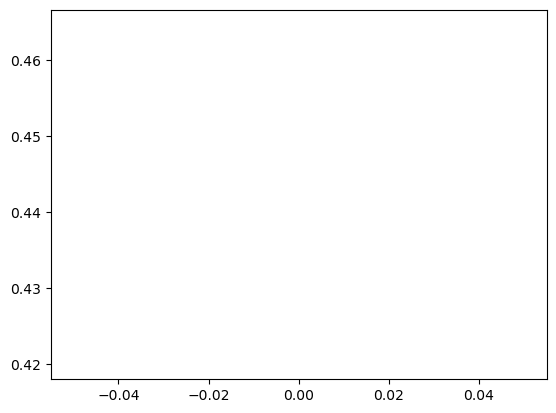

In [7]:
plt.plot(loss_plot)
plt.show()

# Eval with pAUC

In [8]:
model.to("cpu")
model.eval()
correct = 0
total = 0
res = []
with torch.no_grad():
    for i, (x, y, ids) in enumerate(evalloader):
        yhat = model(x)
        if i == 0:
            print(yhat, y, ids)
            print(yhat.item(), y.item(), ids[0])
        res.append([yhat.item(), y.item(), ids[0]])

tensor([[0.9621]]) tensor([1]) ('ISIC_0848536',)
0.9621008038520813 1 ISIC_0848536


In [9]:
submission = pd.DataFrame(res, columns=["yhat", "ytrue", "isic_id"]).drop("ytrue", axis=1)
solution = pd.DataFrame(res, columns=["yhat", "ytrue", "isic_id"]).drop("yhat", axis=1)

In [10]:
utils.score(solution=solution, submission=submission, row_id_column_name="isic_id")

0.13111916264090173

# Check if ids are consistent

In [8]:
# actual = pd.DataFrame(res, columns=["yhat", "ytrue", "isic_id"]).drop("yhat", axis=1)
# expectation = pd.read_csv("train-metadata-sample-100.csv")
# expectation = expectation[["isic_id", "target"]]
# merged = pd.merge(actual, expectation, on="isic_id")
# (merged["ytrue"] == merged["target"]).sum() == len(merged)